<h1> Import Libraries and Boring stuffs </h1>

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from NeuralNetwork import Layer, NeuralNetwork
from PSO import ParticleStructure, Swarm
import itertools
import time

#supress all warnings
import warnings
warnings.filterwarnings('ignore')


<h1> Data File Import and Preprocessing </h1>

In [16]:
#import data to pandas dataframe
df = pd.read_csv('input.csv')

#convert dataframe to numpy array
data_copy = df.values
data = data_copy[:,1:]
print(data)

#data splitting into training and test
X_tv, X_test, y_tv, y_test = train_test_split(data[:,0:5], data[:,5:], test_size = 0.092467, random_state = 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_tv, y_tv, test_size = 0.11111, random_state = 40)


#dimension fix nd reshape
X_train = X_train.astype(float).T
X_validation = X_validation.astype(float).T
X_test = X_test.astype(float).T

y_train = y_train.astype(float).T
y_validation = y_validation.astype(float).T
y_test = y_test.astype(float).T

#function body for prediction mapping
def prediction_mapping(predict):
    predict = np.round(predict, 2)
    predict[predict<0.5] = 0
    predict[predict>=0.5] = 1
    return predict

[[2.65 3.   3.15 ... 0.   0.   1.  ]
 [2.65 3.   3.19 ... 0.   0.   1.  ]
 [2.65 3.   3.18 ... 0.   0.   1.  ]
 ...
 [4.05 3.35 3.8  ... 1.   1.   1.  ]
 [1.4  4.05 3.3  ... 0.   0.   1.  ]
 [4.25 3.   3.25 ... 0.   1.   1.  ]]


<h1> 1. Only Neural Network with Backpropagation </h1>

<p> In this segment, I'll train a simple neural network on the IRIS Dataset and observe how much accuracy it achieves on training and test dataset. Also, I'll record the convergence time in terms of epochs needed. The neural network will have 4 input nodes, 2 hidden layers each having 16 hidden nodes and 3 output nodes. Each output can be (1,0,0) or (0,1,0) or (0,0,1) which represents the three classes - setosa, versicolor and virginica respectively. </p>

Backpropagation Optimization Running
Loss in Epoch 0 =  [3.91916633]
Validation Loss in Epoch 0 =  [3.87395866]
Loss in Epoch 1000 =  [3.2737684]
Validation Loss in Epoch 1000 =  [3.26296014]
Loss in Epoch 2000 =  [3.01624967]
Validation Loss in Epoch 2000 =  [3.00530815]
Runtime of Backprop:  14.090315341949463


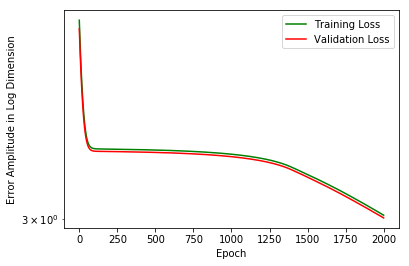

In [3]:
#start timer
tick = time.time()

#training parameters
num_epoch = 2000
epoch = np.arange(0, num_epoch+1)
loss = np.zeros((num_epoch+1, 1))
validation_loss = np.zeros((num_epoch+1, 1))

#network parameters
number_of_hidden_layers = 2
number_of_input_layer_units = X_train.shape[0]
number_of_hidden_layer_units = 8
number_of_output_layer_units = 5
number_of_samples = X_train.shape[1]
hidden_layer_activation = [1,0,0]
N_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                   number_of_output_layer_units, number_of_samples, hidden_layer_activation])
N_Net.structure_define()

#main loop
print("Backpropagation Optimization Running")
for i in range(num_epoch+1):
    N_Net.forward_propagation(X_train)
    loss[i] = N_Net.calculate_network_loss(y_train)
    if(i%1000==0): 
        print("Loss in Epoch", i, "= ", loss[i])
    N_Net.backward_propagation(X_train, y_train)
    #validation_test
    N_Net.forward_propagation(X_validation)
    validation_loss[i] = N_Net.calculate_network_loss(y_validation)
    if(i%1000==0): 
        print("Validation Loss in Epoch", i, "= ", validation_loss[i])

#calculate time
tock = time.time()
print("Runtime of Backprop: ", tock-tick)

#plot
plt.figure(1)
plt.semilogy(epoch, loss, 'g', label='Training Loss')
plt.semilogy(epoch, validation_loss, 'r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error Amplitude in Log Dimension')
plt.show()


<h3> This segment is for showing Performance of N_Net on Test Data </h3>

In [4]:
predict = N_Net.forward_propagation(X_test)
y_predict = prediction_mapping(predict)

y_test = np.where(y_test==1.0, 1, 0)

avg_prec = 0
avg_rec = 0
avg_f1 = 0
avg_accuracy = 0


for i in range(y_test.shape[1]):
    avg_prec = avg_prec + precision_score(y_test[:,i], y_predict[:,i])
    avg_rec = avg_rec + recall_score(y_test[:,i], y_predict[:,i])
    avg_f1 = avg_f1 + f1_score(y_test[:,i], y_predict[:,i])
    avg_accuracy = avg_accuracy + accuracy_score(y_test[:,i], y_predict[:,i])
    
print("Average Precision =", avg_prec/y_test.shape[1])
print("Average Recall =", avg_rec/y_test.shape[1]) 
print("Average F1 Score =", avg_f1/y_test.shape[1])
print ("Average Accuracy =", avg_accuracy/y_test.shape[1])


Average Precision = 0.7335514358415121
Average Recall = 0.6131043256997466
Average F1 Score = 0.6342317079503561
Average Accuracy = 0.6826608505997853


<h1> 2. Neural Network with only PSO (No Backprop) </h1>

<p>In this segment, I modified the neural network a little bit. Now I'll use only Particle Swarm Optimization for the weight updates. No backpropagation will be used. This is tested here because, typical Backpropagation method is prone to get stuck in the "Local Optima" which can probably be solved with Evolutionary Algorithms. [1] </p>
<p> Neural Network will have the same structure as before. Neural Network will be initialized with Random Weights (used np.random.seed() value = 1), and then these weights will be optimized using PSO.</p>
<p>Reference - [1] Palmes, P. P., Hayasaka, T., & Usui, S. (2005). Mutation-Based Genetic Neural Network. IEEE Transactions on Neural Networks, 16(3), 587–600. https://doi.org/10.1109/TNN.2005.844858 </p>

PSO Optimization Running
Iteration Number:  100 Best Cost:  [3.07588259]
Iteration Number:  200 Best Cost:  [3.0059118]
Iteration Number:  300 Best Cost:  [2.87503222]
Iteration Number:  400 Best Cost:  [2.71720816]
Iteration Number:  500 Best Cost:  [2.68677181]
Iteration Number:  600 Best Cost:  [2.66493581]
Iteration Number:  700 Best Cost:  [2.65860797]
Iteration Number:  800 Best Cost:  [2.65278467]
Iteration Number:  900 Best Cost:  [2.64217197]
Iteration Number:  1000 Best Cost:  [2.63835469]
Runtime of PSO Net:  232.85844469070435


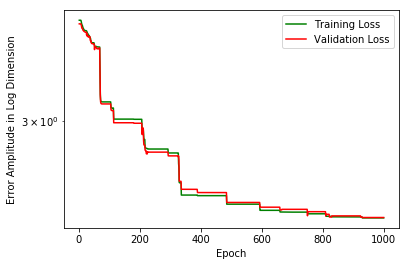

In [5]:
#start timer
tick = time.time()

#global parameters
maxIt = 1000 #number of generations
epoch = np.arange(1, maxIt+1)
nPop = 50
np_loss = np.zeros((maxIt, 1))
validation_loss = np.zeros((maxIt, 1))

#network parameters
number_of_hidden_layers = 2
number_of_input_layer_units = X_train.shape[0]
number_of_hidden_layer_units = 16
number_of_output_layer_units = 5
number_of_samples = X_train.shape[1]
hidden_layer_activation = [1,0,0] #mapped to ReLU
NP_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                   number_of_output_layer_units, number_of_samples, hidden_layer_activation])
NP_Net.structure_define()


#initialize swarm
particleSwarm = Swarm(NP_Net, X_train, y_train, maxIt, nPop, X_validation, y_validation) 
particleSwarm.initialize_swarm(NP_Net)


#run main loop
print("PSO Optimization Running")
NP_Net, np_loss, validation_loss = particleSwarm.pso_loop(NP_Net, np_loss, validation_loss)

#calculate time
tock = time.time()
print("Runtime of PSO Net: ", tock-tick)

#plot
plt.figure(1)
plt.semilogy(epoch, np_loss, 'g', label='Training Loss')
plt.semilogy(epoch, validation_loss, 'r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error Amplitude in Log Dimension')
plt.show()


<h3> This segment is for showing Performance of NP_Net on Test Data </h3>

In [6]:
predict = NP_Net.forward_propagation(X_test)
y_predict = prediction_mapping(predict)

y_test = np.where(y_test==1.0, 1, 0)

avg_prec = 0
avg_rec = 0
avg_f1 = 0
avg_accuracy = 0


for i in range(y_test.shape[1]):
    avg_prec = avg_prec + precision_score(y_test[:,i], y_predict[:,i])
    avg_rec = avg_rec + recall_score(y_test[:,i], y_predict[:,i])
    avg_f1 = avg_f1 + f1_score(y_test[:,i], y_predict[:,i])
    avg_accuracy = avg_accuracy + accuracy_score(y_test[:,i], y_predict[:,i])
    
print("Average Precision =", avg_prec/y_test.shape[1])
print("Average Recall =", avg_rec/y_test.shape[1]) 
print("Average F1 Score =", avg_f1/y_test.shape[1])
print ("Average Accuracy =", avg_accuracy/y_test.shape[1])


Average Precision = 0.802253725917848
Average Recall = 0.5208651399491105
Average F1 Score = 0.6060964843952867
Average Accuracy = 0.6974918211559441


<h1> 3. Initialize Neural Network's Weights with PSO and Update with Backpropagation </h1> 

<p> In this segment, instead of initializing a neural network with random weights, I'll initialize it with specific weights optimized by PSO for 100 iterations with 50 particles in swarm. Once initialized, I'll use typical backpropagation for 1000 iterations for weight optimization. </p>

Iteration Number:  100 Best Cost:  [3.35359744]
Backpropagation Optimization Running
Loss in Epoch 0 =  [3.35359744]
Validation Loss in Epoch 0 =  [3.3366333]
Loss in Epoch 100 =  [3.28337365]
Validation Loss in Epoch 100 =  [3.27322917]
Loss in Epoch 200 =  [3.25237564]
Validation Loss in Epoch 200 =  [3.24396274]
Loss in Epoch 300 =  [3.15496263]
Validation Loss in Epoch 300 =  [3.15276196]
Loss in Epoch 400 =  [2.9131067]
Validation Loss in Epoch 400 =  [2.92657487]
Loss in Epoch 500 =  [2.6451797]
Validation Loss in Epoch 500 =  [2.68023397]
Loss in Epoch 600 =  [2.53803002]
Validation Loss in Epoch 600 =  [2.58414597]
Loss in Epoch 700 =  [2.49474297]
Validation Loss in Epoch 700 =  [2.54547894]
Loss in Epoch 800 =  [2.46926297]
Validation Loss in Epoch 800 =  [2.52236953]
Loss in Epoch 900 =  [2.45077122]
Validation Loss in Epoch 900 =  [2.50519839]
Loss in Epoch 1000 =  [2.43447257]
Validation Loss in Epoch 1000 =  [2.48990323]
Loss in Epoch 1100 =  [2.41742867]
Validation Loss 

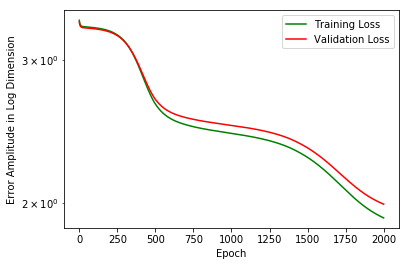

In [7]:
#start timer
tick = time.time()

#global parameters
maxIt = 100 #number of generations
max_epoch = 2000
epoch = np.arange(0, max_epoch+1)
nPop = 30
rand_loss = np.zeros((maxIt, 1))
pb_loss = np.zeros((max_epoch+1, 1))
validation_loss = np.zeros((max_epoch+1, 1))

############################
# Optimize Initial Weights #
############################

#network parameters
number_of_hidden_layers = 2
number_of_input_layer_units = X_train.shape[0]
number_of_hidden_layer_units = 16
number_of_output_layer_units = 5
number_of_samples = X_train.shape[1]
hidden_layer_activation = [1,0,0] #mapped to ReLU
Random_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                   number_of_output_layer_units, number_of_samples, hidden_layer_activation])
Random_Net.structure_define()

#initialize random optimizer swarm
RandOptSwarm = Swarm(Random_Net, X_train, y_train, maxIt, nPop, X_validation, y_validation) #100 generations, 20 particles in each swarm
RandOptSwarm.initialize_swarm(Random_Net)

#run main loop
Rand_Net, rand_loss, validation_loss = RandOptSwarm.pso_loop(Random_Net, rand_loss, validation_loss)

##############################################
# Extract Weights from the Optimized Network #
##############################################
opt_weights_for_hidden_layer_1 = Random_Net.layers[1].weights_from_previous_layer
opt_weights_for_hidden_layer_2 = Random_Net.layers[2].weights_from_previous_layer
opt_weights_for_output_layer   = Random_Net.layers[3].weights_from_previous_layer
opt_biases_for_hidden_layer_1  = Random_Net.layers[1].biases_for_this_layer
opt_biases_for_hidden_layer_2  = Random_Net.layers[2].biases_for_this_layer
opt_biases_for_output_layer    = Random_Net.layers[3].biases_for_this_layer

#######################################
# Initialize Main Neural Net Randomly #
#######################################
#network parameters
number_of_hidden_layers = 2
number_of_input_layer_units = X_train.shape[0]
number_of_hidden_layer_units = 16
number_of_output_layer_units = 5
number_of_samples = X_train.shape[1]
hidden_layer_activation = [1,0,0] #mapped to ReLU
PB_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                   number_of_output_layer_units, number_of_samples, hidden_layer_activation])
PB_Net.structure_define()

##############################################################################
# Replace Main Neural Net's Random weights with previously optimized weights #
##############################################################################
PB_Net.layers[1].weights_from_previous_layer = opt_weights_for_hidden_layer_1
PB_Net.layers[2].weights_from_previous_layer = opt_weights_for_hidden_layer_2
PB_Net.layers[3].weights_from_previous_layer = opt_weights_for_output_layer
PB_Net.layers[1].biases_for_this_layer = opt_biases_for_hidden_layer_1
PB_Net.layers[2].biases_for_this_layer = opt_biases_for_hidden_layer_2
PB_Net.layers[3].biases_for_this_layer = opt_biases_for_output_layer


#remove temporary Random_Net Instance
del Random_Net


######################################################
# Update this optimized network with Backpropagation #
######################################################


#main loop
print("Backpropagation Optimization Running")
for i in range(max_epoch+1):
    PB_Net.forward_propagation(X_train)
    pb_loss[i] = PB_Net.calculate_network_loss(y_train)
    if(i)%100==0: 
        print("Loss in Epoch", i, "= ", pb_loss[i])
    PB_Net.backward_propagation(X_train, y_train)
    #validation_test
    PB_Net.forward_propagation(X_validation)
    validation_loss[i] = PB_Net.calculate_network_loss(y_validation)
    if(i)%100==0: 
        print("Validation Loss in Epoch", i, "= ", validation_loss[i])

#calculate time
tock = time.time()
print("Runtime of PSO-BP Net: ", tock-tick)

#plot
plt.figure(1)
plt.semilogy(epoch, pb_loss, 'g', label='Training Loss')
plt.semilogy(epoch, validation_loss, 'r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error Amplitude in Log Dimension')
plt.show()



<h3> This segment is for showing Performance of PB_Net on Test Data </h3>

In [8]:
predict = PB_Net.forward_propagation(X_test)
y_predict = prediction_mapping(predict)

avg_prec = 0
avg_rec = 0
avg_f1 = 0
avg_accuracy = 0


for i in range(y_test.shape[1]):
    avg_prec = avg_prec + precision_score(y_test[:,i], y_predict[:,i])
    avg_rec = avg_rec + recall_score(y_test[:,i], y_predict[:,i])
    avg_f1 = avg_f1 + f1_score(y_test[:,i], y_predict[:,i])
    avg_accuracy = avg_accuracy + accuracy_score(y_test[:,i], y_predict[:,i])
    
print("Average Precision =", avg_prec/y_test.shape[1])
print("Average Recall =", avg_rec/y_test.shape[1]) 
print("Average F1 Score =", avg_f1/y_test.shape[1])
print ("Average Accuracy =", avg_accuracy/y_test.shape[1])

Average Precision = 0.8398764085786983
Average Recall = 0.8713013449654666
Average F1 Score = 0.8241989925741269
Average Accuracy = 0.8447110141766608


<h1> 4. Neural Network's Structure with (5,20) ES and Weight Update with Backpropagation</h1> 

<p> <b> Structure: </b> In this segment, I'll first select the Neural Network's Structure with (5,20) evolutionary strategies. I'll do this for 10 generations. After 10 generation, the candidate depicting the best structure for a neural network will be used. A neural network will be initialized with that particular structure and with random weights. Then those weights will be updated using typical backpropagation for 1000 epochs. </p>
<p> <b> Chromosome and Gene Details: </b> In (5,20) ES, each chromosome will be a vector like this [4, [1, 0, 0]]. Here, the first element will be an integer between 4-32 inclusive. This will depict the number of nodes in each of the hidden layer. And the second element is a boolean vector which can be mapped - [1, 0, 0] = ReLU, [0, 1, 0] = tanh and [0, 0, 1] = Sigmoid. </p>
<p> <b> Selection for Mutation: </b> Coin toss will be done for selecting whether any gene of the chromosome will be mutated or not. For gene A (number of nodes in hidden layer), selection threshold is set to 30% and for Gene B (boolean vector for activation function selection in hidden layer) is set to 50%. </p>
<p> <b> Mutation Operators: </b> Mutation operator for A is selecting a random number within [4, 32]. Used this instead of random walk to enforce exploration a bit to avoid possible local minima. Mutation operator for Gene B is simple bitwise rightshift. For instance, [1,0,0] -> [0,1,0]; [0,1,0]->[0,0,1] and [0,0,1]->[1,0,0] </p>
<p> <b> Taboo List: </b> I've also maintained a Taboo list of \lamda (population size = 20) size. Whenever a new_child is created, it is first checked whether it is in the taboo list. If yes, then another new_child is created. If not, then the first element is popped from the taboo list and this new_child is appended at the last of the taboo list besides being added as the new member of the main population. So, each new_candidate will get a fair lifetime of 19 new not-present-in-taboo birth. </p>
<p> <b>Fitness Assesment: </b> is done using a simple forward pass without any backward pass. For each candidate structure, a neural network with random weight is created. Then a single forward pass is made and then cost is calculated. This is the measurement of fitness. Lower the cost means fitter the candidate. </p>

---------------------------------------------
Generation  1  Population:
---------------------------------------------
Global Best Loss after Generation:  1 =  [3.34828483]
Global Best Chromosome after Generation:  1 =  [19, [1, 0, 0]]
---------------------------------------------
---------------------------------------------
Generation  2  Population:
---------------------------------------------
Global Best Loss after Generation:  2 =  [3.34828483]
Global Best Chromosome after Generation:  2 =  [19, [1, 0, 0]]
---------------------------------------------
---------------------------------------------
Generation  3  Population:
---------------------------------------------
Global Best Loss after Generation:  3 =  [3.34828483]
Global Best Chromosome after Generation:  3 =  [19, [1, 0, 0]]
---------------------------------------------
---------------------------------------------
Generation  4  Population:
---------------------------------------------
Global Best Loss after Generation: 

Global Best Loss after Generation:  30 =  [3.338114]
Global Best Chromosome after Generation:  30 =  [17, [0, 1, 0]]
---------------------------------------------
Final Result: 
[17, [0, 1, 0]]
[3.338114]
Loss in Epoch 0 =  [3.338114]
Validation Loss in Epoch 0 =  [3.33410489]
Loss in Epoch 100 =  [3.29876193]
Validation Loss in Epoch 100 =  [3.28966596]
Loss in Epoch 200 =  [3.29738271]
Validation Loss in Epoch 200 =  [3.28714959]
Loss in Epoch 300 =  [3.29732822]
Validation Loss in Epoch 300 =  [3.28687263]
Loss in Epoch 400 =  [3.29732013]
Validation Loss in Epoch 400 =  [3.28682179]
Loss in Epoch 500 =  [3.29731319]
Validation Loss in Epoch 500 =  [3.28680665]
Loss in Epoch 600 =  [3.29730578]
Validation Loss in Epoch 600 =  [3.28679766]
Loss in Epoch 700 =  [3.29729813]
Validation Loss in Epoch 700 =  [3.28678968]
Loss in Epoch 800 =  [3.29729029]
Validation Loss in Epoch 800 =  [3.28678171]
Loss in Epoch 900 =  [3.29728184]
Validation Loss in Epoch 900 =  [3.2867732]
Loss in Epoc

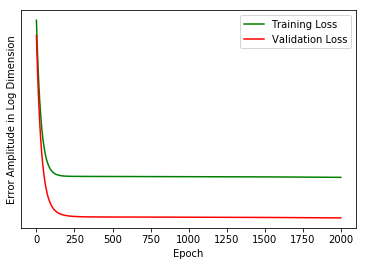

In [9]:
#############################################################################################################
                        # Best Structure Selection by (5,20) Evolutionary Strategies
#############################################################################################################
#start timer
tick = time.time()

#######################################
# Variables
#######################################

#selection parameter
mu = 5
pop_size = 20              #number of child networks (this is \lamda)
pop_parent = []            #parent network hyperparameter container

activation_inside = ['ReLU', 'tanh', 'sigmoid']
activation_bool = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
taboo = [] #add restriction in random selection  
 
#######################################
# Functions
#######################################

# parent initialize in random with restriction of uniqueness
def parent_initialize_in_restriction(chromosome):
    np.random.seed(chromosome)            #initialize all random with fixed seed
    new_candidate = [np.random.randint(4,33), activation_bool[np.random.randint(0,3)]]
    if new_candidate in taboo:
        return "In Taboo"
    else:
        return new_candidate
    #return parent_initialize_in_restriction(chromosome) if new_candidate in taboo else new_candidate

# here we will be selecting top \mu number of parents
# we are basically applying truncation selection

def parentSelection(pop_parent, pop_final_loss):
    fittest_parents = []
    sorted_indices = np.argsort(pop_final_loss, axis=0)
    for i in range(mu):
        fittest_parents.append(pop_parent[sorted_indices[i][0]])
    return fittest_parents

#mutation operator for the first element
def mutationA(selectionA, selected_parents, i, max_bound, min_bound):
    #The Toss for A
    tossA = random.random()
    copy_A = selected_parents[i][0]
    if tossA > selectionA: #selection pressure 30%
        copy_A = np.random.randint(min_bound,max_bound)
    return copy_A
        
#mutation operator for the second element
def mutationB(selectionB, selected_parents, i):
    #The Toss for B
    tossB = random.random()
    copy_B = selected_parents[i][1]
    if tossB > selectionB: #selection pressure 50%
        #Implement bitwise rightshift in boolean vector
        index = selected_parents[i][1].index(1)
        copy_B = [0,0,0]
        index = index + 1
        if index > 2:
            index = 0
        copy_B[index] = 1
    return copy_B                

def breeding(selected_parents):
    max_bound = 129
    min_bound = 4
    pop_parent = []    #empty current population
    #generate lamda children
    for i in range(len(selected_parents)):
        #inner loop control
        for j in range(int(pop_size/mu)):
            #mutation for A
            copyA = mutationA(0.3, selected_parents, i, max_bound, min_bound)
            #mutation for B
            copyB = mutationB(0.5, selected_parents, i)    
            #new child candidate
            new_child = [copyA, copyB]
            #check in taboo list
            check = 1
            while check <= 5:
                if new_child in taboo:   #ensure that no child can be in taboo list
                    copyA = mutationA(0.3, selected_parents, i, max_bound, min_bound)
                    copyB = mutationB(0.5, selected_parents, i)    
                    new_child = [copyA, copyB]
                    check = check + 1
                else:
                    break
            taboo.pop(0)
            taboo.append(new_child)
            pop_parent.append(new_child)
    return pop_parent

####################################
# Step 1: Population Initialization
####################################
c_check = 1 #being used to avoid generating duplicate values already in taboo list from using same seed
for chromosome in range(pop_size):
    new_candidate = parent_initialize_in_restriction(c_check)
    while (new_candidate=="In Taboo"):
        c_check = c_check + 1
        new_candidate = parent_initialize_in_restriction(c_check)
    taboo.append(new_candidate)
    pop_parent.append(new_candidate)

#########################################
# Step 2: ES Loop for fitness assessment
#########################################

best_chromosome = np.zeros((1, 2))
best_loss = 0
round_num = 1
global_best_chromosome = np.zeros((1,2))
global_best_loss = 0

while round_num <=30:
         
    print("---------------------------------------------")
    print("Generation ", round_num, " Population:")
    print("---------------------------------------------")
    pop_final_loss = np.zeros((pop_size, 1))
    for i in range(pop_size):

        ############################################
        # Step 3: Individual Fitness Assessment
        ############################################

        # Neural Network Structure Define
        number_of_hidden_layers = 2
        number_of_input_layer_units = X_train.shape[0]
        number_of_hidden_layer_units = pop_parent[i][0]
        number_of_output_layer_units = 5
        number_of_samples = X_train.shape[1]
        hidden_layer_activation = pop_parent[i][1]
        E_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                           number_of_output_layer_units, number_of_samples, hidden_layer_activation])
        E_Net.structure_define()
        
        #one single forward pass for fitness
        E_Net.forward_propagation(X_train)
        loss = E_Net.calculate_network_loss(y_train)
        
        # Loss calculation
        pop_final_loss[i] = loss

        #save the best candidate
        if i == 0:
            best_chromosome = pop_parent[i]
            best_loss = pop_final_loss[i]
        elif pop_final_loss[i] < best_loss:
            best_chromosome = pop_parent[i]
            best_loss = pop_final_loss[i]
    
    #save global best of all generations
    if round_num==1:
        global_best_loss = best_loss
        global_best_chromosome = best_chromosome
    elif best_loss < global_best_loss:
        global_best_loss = best_loss
        global_best_chromosome = best_chromosome

    print ("Global Best Loss after Generation: ", round_num, "= ", global_best_loss)
    print ("Global Best Chromosome after Generation: ", round_num, "= ", global_best_chromosome)
    print("---------------------------------------------")
    ############################################
    # Step 4: Truncation Selection
    ############################################

    selected_parents = parentSelection(pop_parent, pop_final_loss) #select \mu fittest parents

    ############################################
    # Step 5: Population Regeneration
    ############################################
 
    pop_parent = breeding(selected_parents)
    round_num = round_num + 1
    
print("Final Result: ")
print(global_best_chromosome)
print(global_best_loss)

#####################################################################################################################
        # Initialize Network with this structure, random weights and update weights with backpropagation only
#####################################################################################################################

#############
# Variables #
#############
num_epoch = 2000
epoch = np.arange(0, num_epoch+1)
es_loss = np.zeros((num_epoch+1, 1))
validation_loss = np.zeros((num_epoch+1, 1))

#######################################
# Initialize Main Neural Net Randomly #
#######################################
#network parameters
number_of_hidden_layers = 2
number_of_input_layer_units = X_train.shape[0]
number_of_hidden_layer_units = global_best_chromosome[0]
number_of_output_layer_units = 5
number_of_samples = X_train.shape[1]
hidden_layer_activation = global_best_chromosome[1] 
ES_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                   number_of_output_layer_units, number_of_samples, hidden_layer_activation])
ES_Net.structure_define()

for i in range(num_epoch+1):
    ES_Net.forward_propagation(X_train)
    es_loss[i] = ES_Net.calculate_network_loss(y_train)
    if(i)%100==0: 
        print("Loss in Epoch", i, "= ", es_loss[i])
    ES_Net.backward_propagation(X_train, y_train)
    #validation_test
    ES_Net.forward_propagation(X_validation)
    validation_loss[i] = ES_Net.calculate_network_loss(y_validation)
    if(i)%100==0: 
        print("Validation Loss in Epoch", i, "= ", validation_loss[i])

#calculate time
tock = time.time()
print("Runtime of ES-BP Net: ", tock-tick)

#plot
plt.figure(1)
plt.semilogy(epoch, es_loss, 'g', label='Training Loss')
plt.semilogy(epoch, validation_loss, 'r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error Amplitude in Log Dimension')
plt.show()



<h3> This segment is for showing Performance of ES_Net on Test Data </h3>

In [10]:
predict = ES_Net.forward_propagation(X_test)
y_predict = prediction_mapping(predict)

avg_prec = 0
avg_rec = 0
avg_f1 = 0
avg_accuracy = 0

for i in range(y_test.shape[1]):
    avg_prec = avg_prec + precision_score(y_test[:,i], y_predict[:,i])
    avg_rec = avg_rec + recall_score(y_test[:,i], y_predict[:,i])
    avg_f1 = avg_f1 + f1_score(y_test[:,i], y_predict[:,i])
    avg_accuracy = avg_accuracy + accuracy_score(y_test[:,i], y_predict[:,i])
    
print("Average Precision =", avg_prec/y_test.shape[1])
print("Average Recall =", avg_rec/y_test.shape[1]) 
print("Average F1 Score =", avg_f1/y_test.shape[1])
print ("Average Accuracy =", avg_accuracy/y_test.shape[1])

Average Precision = 0.6472191930207197
Average Recall = 0.49705561613958643
Average F1 Score = 0.5423378511710051
Average Accuracy = 0.6069792802617264


<h1> 5. Neural Network's Structure with (5,20) ES and Best one's Weight Optimize with PSO Only, No Backpropagation. </h1>

<p> In this segment, I'll select the best structure for Neural Network with (5,20) ES. Then I'll initialize a Neural Net with this structure and initialize the weights randomly. Then I'll update the weights with PSO Only. No Backpropagation will be used. </p>

<p> <b> Special Note: </b> In Section 4's Result, we can see that it was stuck in a local minima. After even 1000 epochs of backpropagation, it could not escape it. But, in this section, it can be seen that, the network with the same structure configuration of previous section has escaped local minima successfully due to enforced exploration by PSO.  </p> 

PSO Optimization Running
Iteration Number:  100 Best Cost:  [3.2321088]
Iteration Number:  200 Best Cost:  [3.12584719]
Iteration Number:  300 Best Cost:  [2.93822912]
Iteration Number:  400 Best Cost:  [2.93822912]
Iteration Number:  500 Best Cost:  [2.93822912]
Iteration Number:  600 Best Cost:  [2.93822912]
Iteration Number:  700 Best Cost:  [2.91529953]
Iteration Number:  800 Best Cost:  [2.80957774]
Iteration Number:  900 Best Cost:  [2.77549467]
Iteration Number:  1000 Best Cost:  [2.77549467]
Runtime of ES-PSO Net:  1252.2828562259674


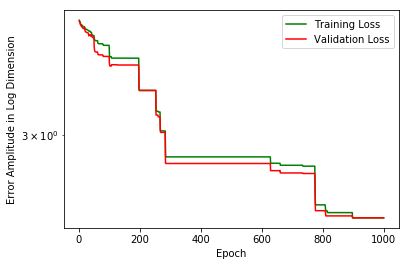

In [11]:
#I'll take the best chromosome found in section 4 as it generated the same best chromosome for almost all the times

#start timer
tick = time.time()

#######################################
# Variables #
#######################################

maxIt = 1000 #number of generations
epoch = np.arange(1, maxIt+1)
nPop = 50
esps_loss = np.zeros((maxIt, 1))
validation_loss = np.zeros((maxIt, 1))

#######################################
# Initialize Main Neural Net Randomly #
#######################################
#network parameters
number_of_hidden_layers = 2
number_of_input_layer_units = X_train.shape[0]
number_of_hidden_layer_units = global_best_chromosome[0]
number_of_output_layer_units = 5
number_of_samples = X_train.shape[1]
hidden_layer_activation = global_best_chromosome[1] 
ESPS_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                   number_of_output_layer_units, number_of_samples, hidden_layer_activation])
ESPS_Net.structure_define()

#initialize swarm
ESPSSwarm = Swarm(ESPS_Net, X_train, y_train, maxIt, nPop, X_validation, y_validation) 
ESPSSwarm.initialize_swarm(ESPS_Net)

#run main loop
print("PSO Optimization Running")
ESPS_Net, esps_loss, validation_loss = ESPSSwarm.pso_loop(ESPS_Net, esps_loss, validation_loss)

#calculate time
tock = time.time()
print("Runtime of ES-PSO Net: ", tock-tick)

#plot
plt.figure(1)
plt.semilogy(epoch, esps_loss, 'g', label='Training Loss')
plt.semilogy(epoch, validation_loss, 'r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error Amplitude in Log Dimension')
plt.show()

<h3> This segment is for showing Performance of ESPS_Net on Test Data </h3>

In [12]:
predict = ESPS_Net.forward_propagation(X_test)
y_predict = prediction_mapping(predict)

avg_prec = 0
avg_rec = 0
avg_f1 = 0
avg_accuracy = 0


for i in range(y_test.shape[1]):
    avg_prec = avg_prec + precision_score(y_test[:,i], y_predict[:,i])
    avg_rec = avg_rec + recall_score(y_test[:,i], y_predict[:,i])
    avg_f1 = avg_f1 + f1_score(y_test[:,i], y_predict[:,i])
    avg_accuracy = avg_accuracy + accuracy_score(y_test[:,i], y_predict[:,i])
    
print("Average Precision =", avg_prec/y_test.shape[1])
print("Average Recall =", avg_rec/y_test.shape[1]) 
print("Average F1 Score =", avg_f1/y_test.shape[1])
print ("Average Accuracy =", avg_accuracy/y_test.shape[1])

Average Precision = 0.7016539440203559
Average Recall = 0.703507815339876
Average F1 Score = 0.6716310951861634
Average Accuracy = 0.6907306434023988


<h1> 6. Neural Network's Structure with (5,20) ES and Best One's Weight Initialize with PSO and Update with Backprop </h1>

<p> In this final segment, A Neural Network's Structure that was fixed in Segment 4 will be used. Then, a random network's (same structure) initial weight will be optimized by 100 rounds of PSO with 50 Particles each. Then with that optimized weight and structure the final neural network will be instantiated and then will be optimized with 1000 rounds of back propagation. </p> 

PSO Optimization Running
Iteration Number:  100 Best Cost:  [3.32994865]
Backpropagation Optimization Running
Loss in Epoch 0 =  [3.32994865]
Validation Loss in Epoch 0 =  [3.32675465]
Loss in Epoch 100 =  [3.29744847]
Validation Loss in Epoch 100 =  [3.28812211]
Loss in Epoch 200 =  [3.2851398]
Validation Loss in Epoch 200 =  [3.27560572]
Loss in Epoch 300 =  [3.25609656]
Validation Loss in Epoch 300 =  [3.2472935]
Loss in Epoch 400 =  [3.23526748]
Validation Loss in Epoch 400 =  [3.22747747]
Loss in Epoch 500 =  [3.22836825]
Validation Loss in Epoch 500 =  [3.2219939]
Loss in Epoch 600 =  [3.222284]
Validation Loss in Epoch 600 =  [3.21781479]
Loss in Epoch 700 =  [3.21631738]
Validation Loss in Epoch 700 =  [3.21360466]
Loss in Epoch 800 =  [3.2101023]
Validation Loss in Epoch 800 =  [3.20871063]
Loss in Epoch 900 =  [3.20180843]
Validation Loss in Epoch 900 =  [3.20151005]
Loss in Epoch 1000 =  [3.18220562]
Validation Loss in Epoch 1000 =  [3.18457195]
Loss in Epoch 1100 =  [3.1487

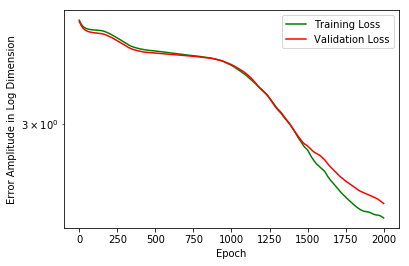

In [13]:
#start timer
tick = time.time()

#global parameters
maxIt = 100 #number of generations
max_epoch = 2000
epoch = np.arange(0, max_epoch+1)
nPop = 20
rand_loss = np.zeros((maxIt, 1))
espsb_loss = np.zeros((max_epoch+1, 1))
validation_loss = np.zeros((max_epoch+1, 1))

############################
# Optimize Initial Weights #
############################

#network parameters
number_of_hidden_layers = 2
number_of_input_layer_units = X_train.shape[0]
number_of_hidden_layer_units = global_best_chromosome[0]
number_of_output_layer_units = 5
number_of_samples = X_train.shape[1]
hidden_layer_activation = global_best_chromosome[1] 
Random_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                   number_of_output_layer_units, number_of_samples, hidden_layer_activation])
Random_Net.structure_define()

#initialize random optimizer swarm
RandOptSwarm = Swarm(Random_Net, X_train, y_train, maxIt, nPop, X_validation, y_validation) #100 generations, 20 particles in each swarm
RandOptSwarm.initialize_swarm(Random_Net)

#run main loop
print("PSO Optimization Running")
Random_Net, rand_loss, validation_loss = RandOptSwarm.pso_loop(Random_Net, rand_loss, validation_loss)


##############################################
# Extract Weights from the Optimized Network #
##############################################
opt_weights_for_hidden_layer_1 = Random_Net.layers[1].weights_from_previous_layer
opt_weights_for_hidden_layer_2 = Random_Net.layers[2].weights_from_previous_layer
opt_weights_for_output_layer   = Random_Net.layers[3].weights_from_previous_layer
opt_biases_for_hidden_layer_1  = Random_Net.layers[1].biases_for_this_layer
opt_biases_for_hidden_layer_2  = Random_Net.layers[2].biases_for_this_layer
opt_biases_for_output_layer    = Random_Net.layers[3].biases_for_this_layer

#######################################
# Initialize Main Neural Net Randomly #
#######################################
#network parameters
number_of_hidden_layers = 2
number_of_input_layer_units = X_train.shape[0]
number_of_hidden_layer_units = global_best_chromosome[0]
number_of_output_layer_units = 5
number_of_samples = X_train.shape[1]
hidden_layer_activation = global_best_chromosome[1]
ESPSB_Net = NeuralNetwork([number_of_hidden_layers, number_of_input_layer_units, number_of_hidden_layer_units, \
                   number_of_output_layer_units, number_of_samples, hidden_layer_activation])
ESPSB_Net.structure_define()

##############################################################################
# Replace Main Neural Net's Random weights with previously optimized weights #
##############################################################################
ESPSB_Net.layers[1].weights_from_previous_layer = opt_weights_for_hidden_layer_1
ESPSB_Net.layers[2].weights_from_previous_layer = opt_weights_for_hidden_layer_2
ESPSB_Net.layers[3].weights_from_previous_layer = opt_weights_for_output_layer
ESPSB_Net.layers[1].biases_for_this_layer = opt_biases_for_hidden_layer_1
ESPSB_Net.layers[2].biases_for_this_layer = opt_biases_for_hidden_layer_2
ESPSB_Net.layers[3].biases_for_this_layer = opt_biases_for_output_layer


#remove temporary Random_Net Instance
del Random_Net


######################################################
# Update this optimized network with Backpropagation #
######################################################


#main loop
print("Backpropagation Optimization Running")
for i in range(max_epoch+1):
    ESPSB_Net.forward_propagation(X_train)
    espsb_loss[i] = ESPSB_Net.calculate_network_loss(y_train)
    if(i)%100==0: 
        print("Loss in Epoch", i, "= ", espsb_loss[i])
    ESPSB_Net.backward_propagation(X_train, y_train)
    #validation_test
    ESPSB_Net.forward_propagation(X_validation)
    validation_loss[i] = ESPSB_Net.calculate_network_loss(y_validation)
    if(i)%100==0: 
        print("Validation Loss in Epoch", i, "= ", validation_loss[i])

    
#calculate time
tock = time.time()
print("Runtime of ES-PSO-BP Net: ", tock-tick)    

#plot
plt.figure(1)
plt.semilogy(epoch, espsb_loss, 'g', label='Training Loss')
plt.semilogy(epoch, validation_loss, 'r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error Amplitude in Log Dimension')
plt.show()


<h3> This segment is for showing Performance of ESPSB_Net on Test Data </h3>

In [14]:
predict = ESPSB_Net.forward_propagation(X_test)
y_predict = prediction_mapping(predict)

avg_prec = 0
avg_rec = 0
avg_f1 = 0
avg_accuracy = 0


for i in range(y_test.shape[1]):
    avg_prec = avg_prec + precision_score(y_test[:,i], y_predict[:,i])
    avg_rec = avg_rec + recall_score(y_test[:,i], y_predict[:,i])
    avg_f1 = avg_f1 + f1_score(y_test[:,i], y_predict[:,i])
    avg_accuracy = avg_accuracy + accuracy_score(y_test[:,i], y_predict[:,i])
    
print("Average Precision =", avg_prec/y_test.shape[1])
print("Average Recall =", avg_rec/y_test.shape[1]) 
print("Average F1 Score =", avg_f1/y_test.shape[1])
print ("Average Accuracy =", avg_accuracy/y_test.shape[1])

Average Precision = 0.7069247546346783
Average Recall = 0.7957651762995266
Average F1 Score = 0.7136625642623429
Average Accuracy = 0.7306434023991274
